1. linreg for EGTM, 1 engine only
2. tune theta degree
3. tune altitude + bleed ensemble

In [57]:
from deltas import *

bdu_all = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('pos == 2 and reportts >= "2019-01-01"')
bdu_all = correct(bdu_all)


In [50]:
bdu_all.shape 

(782, 217)

Setup the experiment:

In [51]:
best_rmse = 1000
best_model = None
best_pred = None

alpha = 0.5
alpha_2 = 0.84

x_variants = ['n1_peak', 'n1a_peak', 'n1c2_peak', 'n1com_peak', 'n1max_peak', 'n2a_peak', 'nf_peak']
y_variants = ['egt', 'egt_peak', 'egtb']
theta_variants = ['oat', 'oat_peak', 't2', 't2_peak', 'tat', 'tat_peak']

hall_of_fame = []

In [52]:
def theta_correct(data, x_param, y_param, theta_param):
  theta = (data[theta_param] + 273.16) / 288.16
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (theta ** alpha_2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

for x_param in x_variants:
  for y_param in y_variants:
    for theta_param in theta_variants:
      bdu = bdu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
      x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
      bdu = theta_correct(bdu, x_param, y_param, theta_param)
      assert bdu.shape[0] >= 200
      baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
      egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

      X = pd.DataFrame(smooth(egtm, 0.05))
      lin_model = LinearRegression()
      lin_model.fit(X, y=bdu['egtm'])

      pred = lin_model.predict(X)
      
      rmse = root_mean_squared_error(bdu['egtm'], pred)

      if rmse < best_rmse:
        best_pred = pred
        best_rmse = rmse
        best_model = lin_model

      hall_of_fame.append({
        'x_param': x_param,
        'y_param': y_param, 
        'theta_param': theta_param,
        'rmse': rmse
      })


In [54]:
hall_of_fame = pd.DataFrame(hall_of_fame)

In [55]:
hall_of_fame.sort_values('rmse')

,x_param,y_param,theta_param,rmse
114,nf_peak,egt_peak,oat,2.382369
100,n2a_peak,egt_peak,tat,2.400371
24,n1a_peak,egt_peak,oat,2.402504
60,n1com_peak,egt_peak,oat,2.403961
30,n1a_peak,egtb,oat,2.404745
...,...,...,...,...
78,n1max_peak,egt_peak,oat,5.607913
81,n1max_peak,egt_peak,t2_peak,6.210337
83,n1max_peak,egt_peak,tat_peak,6.306039
79,n1max_peak,egt_peak,oat_peak,6.436416


Plot best result: 

ValueError: x and y must have same first dimension, but have shapes (782,) and (770,)

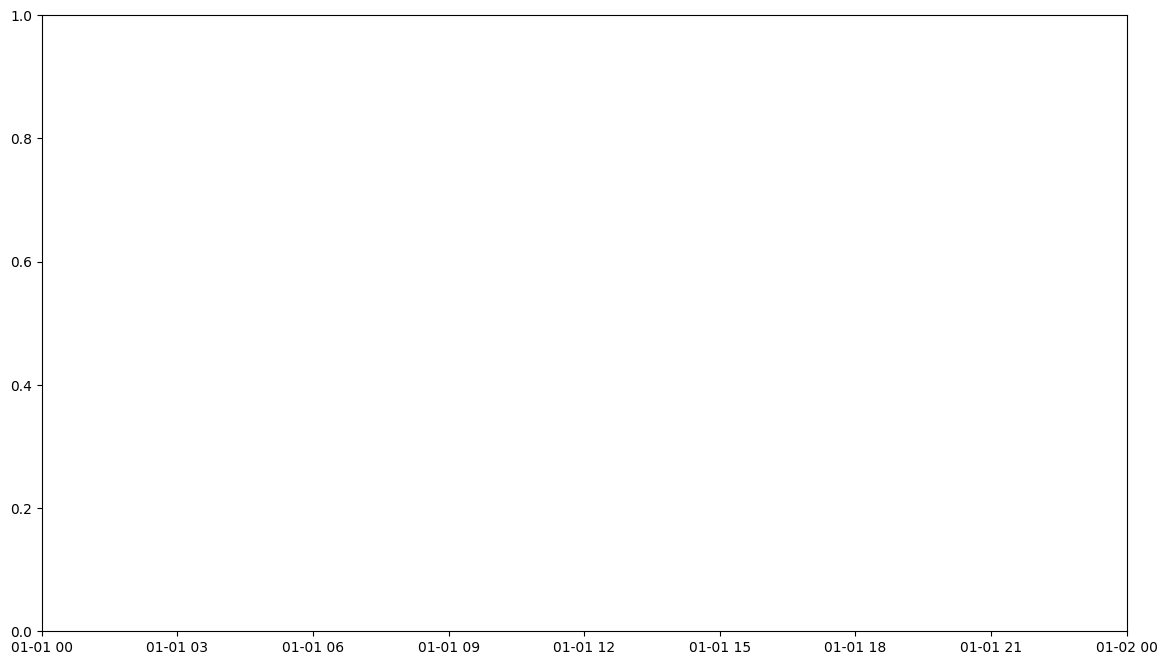

In [56]:
import matplotlib.pyplot as plt

bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.plot(bdu['reportts'], best_pred)
plt.scatter(bdu['reportts'], bdu['egtm'], s=1)
plt.show()